<a href="https://colab.research.google.com/github/Youngdeuk-Koo/KNLP/blob/main/%ED%95%9C%EA%B8%80_%EC%9D%BC%EB%B3%B8%EC%96%B4_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import sentencepiece as spm
import tensorflow as tf
import gensim
import gdown
import zipfile
from konlpy.tag import Mecab
mecab = Mecab()

In [4]:
import zipfile

path_train = '/content/drive/MyDrive/AI_Study/NLP/DATA/번역 Corpus/[원천]ko2ja_culture_training_csv.zip'
path_val = '/content/drive/MyDrive/AI_Study/NLP/DATA/번역 Corpus/[원천]ko2ja_culture_validation_csv.zip'

with zipfile.ZipFile(path_train, 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(path_val, 'r') as zip_ref:
    zip_ref.extractall()

In [44]:
import pandas as pd

train_auto = pd.read_csv('/content/ko2ja_auto_1_training.csv', encoding='utf-8')
train_edu = pd.read_csv('/content/ko2ja_edu_1_training.csv', encoding='utf-8')
train_finance = pd.read_csv('/content/ko2ja_finance_1_training.csv', encoding='utf-8')
train_folk = pd.read_csv('/content/ko2ja_folk_1_training.csv', encoding='utf-8')
train_tech = pd.read_csv('/content/ko2ja_it_tech_1_training.csv', encoding='utf-8')
train_kpop = pd.read_csv('/content/ko2ja_kpop_1_training.csv', encoding='utf-8')
train_medical = pd.read_csv('/content/ko2ja_medical_1_training.csv', encoding='utf-8')
train_patent = pd.read_csv('/content/ko2ja_patent_1_training.csv', encoding='utf-8')
train_society = pd.read_csv('/content/ko2ja_society_1_training.csv', encoding='utf-8')

validation_auto = pd.read_csv('/content/ko2ja_auto_2_validation.csv', encoding='utf-8')
validation_edu = pd.read_csv('/content/ko2ja_edu_2_validation.csv', encoding='utf-8')
validation_finance = pd.read_csv('/content/ko2ja_finance_2_validation.csv', encoding='utf-8')
validation_folk = pd.read_csv('/content/ko2ja_folk_2_validation.csv', encoding='utf-8')
validation_tech = pd.read_csv('/content/ko2ja_it_tech_2_validation.csv', encoding='utf-8')
validation_kpop = pd.read_csv('/content/ko2ja_kpop_2_validation.csv', encoding='utf-8')
validation_medical = pd.read_csv('/content/ko2ja_medical_2_validation.csv', encoding='utf-8')
validation_patent = pd.read_csv('/content/ko2ja_patent_2_validation.csv', encoding='utf-8')
validation_society = pd.read_csv('/content/ko2ja_society_2_validation.csv', encoding='utf-8')

In [46]:
df = pd.concat((train_auto, train_edu, train_finance, train_folk, train_tech, train_kpop, train_medical, train_patent, 
                train_society,validation_auto, validation_edu, validation_finance, validation_folk, validation_tech, 
                validation_kpop, validation_medical, validation_patent, validation_society), axis=0)

df.head()

,관리번호,분야,한국어,일본어,한국어_어절수,일본어_글자수,길이_분류,출처,수행기관
0,KO-JA-2020-AUTO-000001,자동차/부품/교통/소재,지원 금액은 차종과 연식에 따라 보험개발원이 산정한 차량기준가액을 적용한다.,支援金額は車種と年式によって保険開発院が算定した車両基準価額を適用する。,9,35,1,http://www.asiae.co.kr/article/202005201702158...,에버트란
1,KO-JA-2020-AUTO-000002,자동차/부품/교통/소재,이 대표는 기업간거래(B2B)용 연구개발(R&D) 칩으로 수익을 내면 모바일 기기와...,イ代表は、企業間取引(B2B)用の研究開発(R&D)チップで収益を出せば、モバイル機器と自動...,18,62,3,http://www.etnews.com/20200408000179,에버트란
2,KO-JA-2020-AUTO-000003,자동차/부품/교통/소재,쌍용자동차가 코란도 스포츠의 출시를 기념해 고객들이 코란도 스포츠의 활용성을 체험할...,双龍自動車がコランドスポーツの発売を記念し、顧客がコランドスポーツの活用性を体験できる多彩な...,17,60,3,NaN,에버트란
3,KO-JA-2020-AUTO-000004,자동차/부품/교통/소재,르노삼성은 현금할인에 각종 용품 장착 지원을 통해 반등에 나선다.,ルノーサムスンは現金割引に各種用品の装着支援を通じて持ち直しを狙う。,9,32,1,NaN,에버트란
4,KO-JA-2020-AUTO-000005,자동차/부품/교통/소재,2개의 냉각수 시스템과 6기통의 복스터 엔진은 테크아트 파워 키트를 통해 개선됐다.,2つの冷却水システムと6気筒のボクスターエンジンは、テックアートパワーキットにより改善された。,11,40,2,NaN,에버트란


Data Size Check : 1350000 

>> Null값이 존재하지 않습니다 

>> 중복값이 존재하지 않습니다 

>> 그래프를 출력합니다 



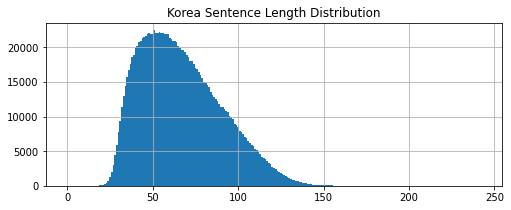

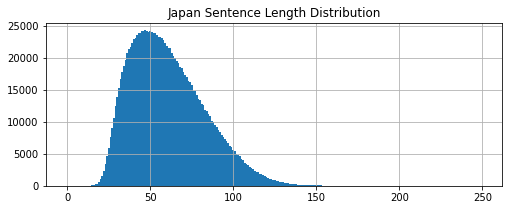


>> 한국어 문장 최장 길이 : 243 

>> 한국어 문장 최단 길이 : 11 

>> 일본어 문장 최장 길이 : 250 

>> 일본어 문장 최장 길이 : 9 

>> 문장을 자르고 있습니다 

>> 그래프를 출력합니다 



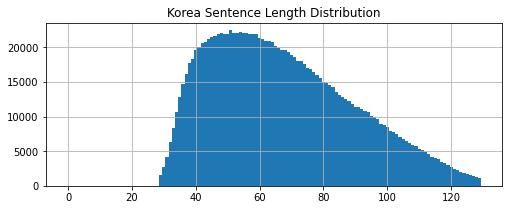

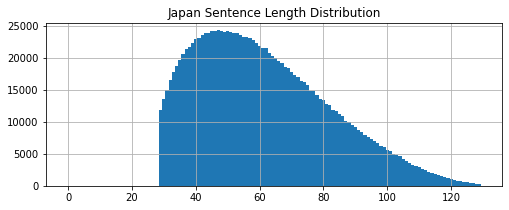


>> 전처리된 한국어 문장 최장 길이 : 130 

>> 전처리된 한국어 문장 최단 길이 : 30 

>> 전처리된 일본어 문장 최장 길이 : 130 

>> 전처리된 일본어 문장 최장 길이 : 30 



In [47]:
def Clean_data_generation(train, sentence1=None, sentence2=None, null_check=False, duplicates_check=False, sentence_length_count_check=False, sentence_trunk=False):

    print('Data Size Check :', len(train), '\n')

    ex_len = len(train)

    if null_check == True :

        if (False in train[sentence1].isnull()) or (False in train[sentence2].isnull())== False:
            print('>> Null값이 존재하지 않습니다', '\n')

        else:
            train.dropna(how='any')
            print('>> Null값이 제거 됐습니다', '\n')
            print('>> Data Size check :', len(train), '\n')

    else :
        print('>> Null값을 제거하지 않습니다', '\n')

    if duplicates_check == True :

        if (True in train.duplicated([sentence1, sentence2], keep='first')) == True:
            print('>> 중복값이 존재하지 않습니다', '\n')

        else:
            train.drop_duplicates(subset=[sentence1, sentence2], keep='first', inplace=True, ignore_index=False)
            print('>> 중복값이 제거 됐습니다', '\n')
            print('>> 제거된 중복값 갯수 :', (ex_len - len(train)), '\n')
            print('>> Data Size check :', len(train), '\n')

    else :
        print('>> 중복값을 제거하지 않습니다', '\n')


    if sentence_length_count_check == True:
        print('>> 그래프를 출력합니다', '\n')

        kor = train[sentence1]
        jap = train[sentence2]

        k_max_len = max([len(w) for w in kor])
        k_min_len = min([len(w) for w in kor])
        j_max_len = max([len(w) for w in jap])
        j_min_len = min([len(w) for w in jap])


        kor_length = np.zeros((k_max_len), dtype=np.uint)
        jap_length = np.zeros((j_max_len), dtype=np.uint)

        for k_sen, e_sen in zip(kor, jap): #중복이 제거된 코퍼스
            kor_length[len(k_sen)-1] += 1
            jap_length[len(e_sen)-1] += 1


        plt.figure(figsize=[18, 3])
        plt.subplot(1, 2, 1)
        plt.title("Korea Sentence Length Distribution")
        plt.bar(range(k_max_len), kor_length, width=1.0)
        plt.grid()

        plt.figure(figsize=[18, 3])
        plt.subplot(1, 2, 2)
        plt.bar(range(j_max_len), jap_length, width=1.0)
        plt.title("Japan Sentence Length Distribution")
        plt.grid()
        plt.show()
        
        print()
        print('>> 한국어 문장 최장 길이 :', k_max_len, '\n')
        print('>> 한국어 문장 최단 길이 :', k_min_len, '\n')
        print('>> 일본어 문장 최장 길이 :', j_max_len, '\n')
        print('>> 일본어 문장 최장 길이 :', j_min_len, '\n') 


    else:
        print('>> 그래프를 출력하지 않습니다', '\n')     

    if sentence_trunk == True:

        print('>> 문장을 자르고 있습니다', '\n')

        train['k_sen_len'] = train[sentence1].str.len()
        train['j_sen_len'] = train[sentence2].str.len()

        train = train[(train['k_sen_len'] <= 130) & (train['j_sen_len'] <= 130)]
        train = train[(train['k_sen_len'] >= 30) & (train['j_sen_len'] >= 30)]

        kor = train[sentence1]
        jap = train[sentence2]

        k_max_len = max([len(w) for w in kor])
        k_min_len = min([len(w) for w in kor])
        j_max_len = max([len(w) for w in jap])
        j_min_len = min([len(w) for w in jap])


        kor_length = np.zeros((k_max_len), dtype=np.uint)
        jap_length = np.zeros((j_max_len), dtype=np.uint)

        for k_sen, e_sen in zip(kor, jap): #중복이 제거된 코퍼스
            kor_length[len(k_sen)-1] += 1
            jap_length[len(e_sen)-1] += 1

        print('>> 그래프를 출력합니다', '\n')

        plt.figure(figsize=[18, 3])
        plt.subplot(1, 2, 1)
        plt.title("Korea Sentence Length Distribution")
        plt.bar(range(k_max_len), kor_length, width=1.0)
        plt.grid()

        plt.figure(figsize=[18, 3])
        plt.subplot(1, 2, 2)
        plt.bar(range(j_max_len), jap_length, width=1.0)
        plt.title("Japan Sentence Length Distribution")
        plt.grid()
        plt.show()
        
        print()
        print('>> 전처리된 한국어 문장 최장 길이 :', k_max_len, '\n')
        print('>> 전처리된 한국어 문장 최단 길이 :', k_min_len, '\n')
        print('>> 전처리된 일본어 문장 최장 길이 :', j_max_len, '\n')
        print('>> 전처리된 일본어 문장 최장 길이 :', j_min_len, '\n') 

    else:
        print('>> 문장을 자르지 않습니다', '\n') 

    return train

df = Clean_data_generation(df, 
                           sentence1='한국어',
                           sentence2='일본어',
                           null_check=True, 
                           duplicates_check=True, 
                           sentence_length_count_check=True,
                           sentence_trunk=True)

#데이터 불러오기

In [48]:
def build_corpus(src, lan='kor'):
    import re

    try:    # 소문자가 있을시
        src = src.lower()

    except: # 소문자가 없을시
        pass

    if lan == 'kor':
        src = str(src).replace('・', ' ')
        src = src.replace('·', ' ')
        src = src.replace('-', ' ')
        src = re.sub(r'\([^)]*\)', '', src)
        src = re.sub(r'\[[^)]*\]', '', src)
        src = re.sub('[-=+#/\:;^$@*\’"“”※&ㆍ_『』\\‘|\(\)\[\]\<\>`\'"…》、㎝]','', src)
        src = re.sub(r"([?!.,%〜∼])", r" \1 ", src)
        src = re.sub('[0-9] \. [0-9]', '6.7', src)
        src = re.sub('[0-9] , [0-9]', '6,7', src)
        # src = re.sub(' \. ', '', src)
        return src

    if lan == 'jap':
        src = str(src).replace('、', ', ')
        # src = src.replace('、', ', ')
        # src = src.replace('。', '.')
        src = src.replace('・', ', ')
        src = re.sub(r'\([^)]*\)', '', src)
        src = re.sub('[-=+,#/\:;^$@*\’"“”※~&ㆍ_『』\\‘|\(\)\[\]\<\>〈〉`\'"…》㎝「」]','', src)
        src = re.sub(r"([?!〜.%。、,])", r" \1 ", src)
        src = re.sub('[0-9] \. [0-9]', '6.7', src)
        src = re.sub('[0-9] , [0-9]', '6,7', src)
        src = re.sub(' \. ', '', src)   
        return src

In [49]:
clean_kor = [build_corpus(w, 'kor') for w in df['한국어']]
clean_jap = [build_corpus(w, 'jap') for w in df['일본어']]

In [ ]:
pair = [w for w in zip(clean_kor, clean_jap)]
pair

#전처리 언어 저장

In [53]:
g_drive_path = '/content/drive/MyDrive/AI_Study/NLP/DATA/한국_일본 text/'

with open(g_drive_path + 'clean_ko_corpus.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(map(str, clean_kor)))

with open(g_drive_path + 'clean_ja_corpus.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(map(str, clean_jap)))